<h1 align="center"><font color='blue'>Title In Progress </font></h1>


<div class="alert alert-block alert-info" style="color: black;">
<h2>Goals Achieved in this Notebook:</h2>
<ul>
    <li>Reading the GRACE Data</li>
    <li>Extracting the entire Colorado River Basin as well as only the Colorado River Basin States from the GRACE data</li>
    <li>Visualizing land water equivalent for the entire Colorado River Basin as well as for only the Colorado River Basin States across time (2002-2023)</li>
</ul>
</div>

<div class="alert alert-block alert-info" style = "color: black;">
<p>Below are the list of libraries that are needed for this script to run.</p>
</div>

In [3]:
!pip3 install netCDF4
!pip3 install pandas
!pip3 install numpy
!pip3 install imageio
!pip3 install geodatasets
!pip3 install pyshp
import netCDF4 as nc
import pandas as pd
import os
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import collections
import matplotlib.font_manager
import xarray as xr
import statistics
import geodatasets
import shapefile
from shapely.geometry import shape, Point
import imageio



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


<div class="alert alert-block alert-info" style="color: black;">
<p>Next, we loaded the Grace data. Instructions on how to download the grace data can be found <a href="https://neoproterozoic.ess.washington.edu/jhub/user/asetia/notebooks/DSSG2023-Groundwater/Snippets/Asetia1/Instructions%20on%20Downloading%20the%20GRACE%20Data.ipynb">here</a>.</p>
    
<p>The GRACE data has longitude values in the range [0,360]. Therefore, in the code below, we have converted it to the range of [-180,180] as the other datasets of interest have latitude and longitude values in that range.</p>
<p>We have also multiplied the land water equivalent <code>lwe_thickness</code> with the appropriate scaling factor <code>scale_Factor</code> and stored it in the variable <code>lwe</code>.</p>
</div>


In [4]:
#Reading Grace Data (mascon)
grace_path = '/home/asetia/remoteData/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/'
df = xr.open_dataset(grace_path+"GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc")
d = df.to_dataframe()
d.reset_index(inplace=True)
data = d[["time","lat","lon","lwe_thickness","scale_factor"]]
data2 = data[data.lwe_thickness.notnull()] 
grace_data = data2[data2.scale_factor.notnull()] 

grace_data["lwe"] = [x*y for x,y in zip(grace_data["lwe_thickness"],grace_data["scale_factor"])] #multiplying scaling factor
grace_data["lon"] = [k-180 for k in grace_data["lon"]] #converting longitude points



/tmp/ipykernel_595741/682003137.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grace_data["lwe"] = [x*y for x,y in zip(grace_data["lwe_thickness"],grace_data["scale_factor"])] #multiplying scaling factor
/tmp/ipykernel_595741/682003137.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grace_data["lon"] = [k-180 for k in grace_data["lon"]] #converting longitude points


In [7]:
# Reading Grace Data (mascon)
grace_path = '/home/asetia/remoteData/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/'
df = xr.open_dataset(grace_path + "GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc")
d = df.to_dataframe()
d.reset_index(inplace=True)
data = d[["time", "lat", "lon", "lwe_thickness", "scale_factor"]]
data2 = data.dropna(subset=["lwe_thickness", "scale_factor"])  # Drop rows with null values in specified columns
grace_data = data2.drop_duplicates()  # Remove duplicate rows

grace_data["lwe"] = grace_data["lwe_thickness"] * grace_data["scale_factor"]  # multiplying scaling factor
grace_data["lon"] = grace_data["lon"] - 180  # converting longitude points


/tmp/ipykernel_595741/213572473.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grace_data["lwe"] = grace_data["lwe_thickness"] * grace_data["scale_factor"]  # multiplying scaling factor
/tmp/ipykernel_595741/213572473.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grace_data["lon"] = grace_data["lon"] - 180  # converting longitude points


In [8]:
grace_data

,time,lat,lon,lwe_thickness,scale_factor,lwe
84040,2002-04-17 12:00:00,5.75,-179.75,-13.136055,0.011175,-0.146790
84042,2002-05-10 12:00:00,5.75,-179.75,-11.470655,0.011175,-0.128180
84044,2002-08-16 12:00:00,5.75,-179.75,-3.586978,0.011175,-0.040083
84046,2002-09-16 00:00:00,5.75,-179.75,-0.564681,0.011175,-0.006310
84048,2002-10-16 12:00:00,5.75,-179.75,2.739548,0.011175,0.030613
...,...,...,...,...,...,...
114016310,2022-12-16 12:00:00,53.75,179.75,-9.774596,0.951602,-9.301526
114016312,2023-01-16 12:00:00,53.75,179.75,-8.168959,0.951602,-7.773599
114016314,2023-02-15 00:00:00,53.75,179.75,-10.522227,0.951602,-10.012974
114016316,2023-03-16 12:00:00,53.75,179.75,-8.131388,0.951602,-7.737846


In [31]:
collections.Counter(grace_data["time"]).keys()

dict_keys([Timestamp('2002-04-17 12:00:00'), Timestamp('2002-05-10 12:00:00'), Timestamp('2002-08-16 12:00:00'), Timestamp('2002-09-16 00:00:00'), Timestamp('2002-10-16 12:00:00'), Timestamp('2002-11-16 00:00:00'), Timestamp('2002-12-16 12:00:00'), Timestamp('2003-01-16 12:00:00'), Timestamp('2003-02-15 00:00:00'), Timestamp('2003-03-16 12:00:00'), Timestamp('2003-04-16 00:00:00'), Timestamp('2003-05-11 12:00:00'), Timestamp('2003-07-16 12:00:00'), Timestamp('2003-08-16 12:00:00'), Timestamp('2003-09-16 00:00:00'), Timestamp('2003-10-16 00:00:00'), Timestamp('2003-11-16 00:00:00'), Timestamp('2003-12-16 12:00:00'), Timestamp('2004-01-07 12:00:00'), Timestamp('2004-02-17 00:00:00'), Timestamp('2004-03-16 12:00:00'), Timestamp('2004-04-16 00:00:00'), Timestamp('2004-05-16 12:00:00'), Timestamp('2004-06-16 00:00:00'), Timestamp('2004-07-16 12:00:00'), Timestamp('2004-08-16 12:00:00'), Timestamp('2004-09-16 00:00:00'), Timestamp('2004-10-16 12:00:00'), Timestamp('2004-11-16 00:00:00'), Tim

<div class="alert alert-block alert-info" style="color: black;">
Next, in the code below, we have downloaded the shape file of <a href="https://coloradoriverbasin-lincolninstitute.hub.arcgis.com/datasets/colorado-river-basin-hydrological-boundaries-with-areas-served-by-colorado-river/explore?location=37.047204%2C-110.573590%2C6.40">Colorado River Basin</a> in the format of an SHP file. The shape file is a geospatial data format used for representing geographic features. The SHP file stores the geometric data of the shapefile, such as points, lines, or polygons, representing the boundaries and other features of the Colorado River Basin.
</div>



In [9]:
#Loading shapefile of CRB (comprising of 8 total regions, including Upper and Lower basin)
crb = gpd.read_file("/home/asetia/code/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")


<Figure size 1000x1000 with 0 Axes>

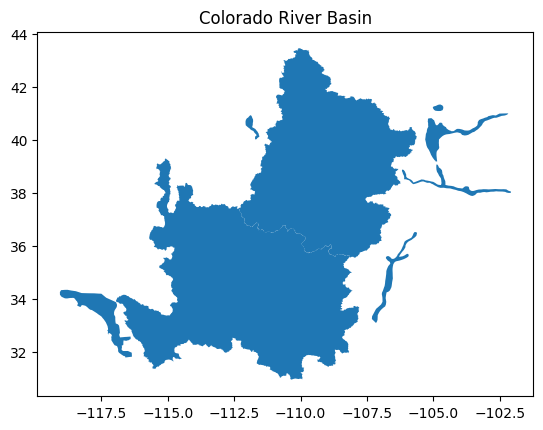

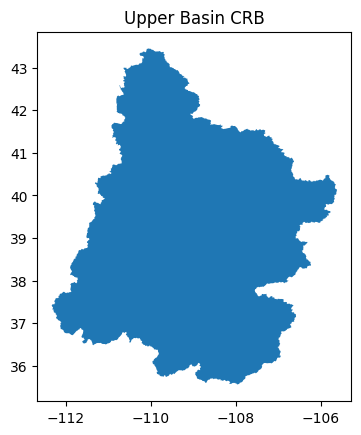

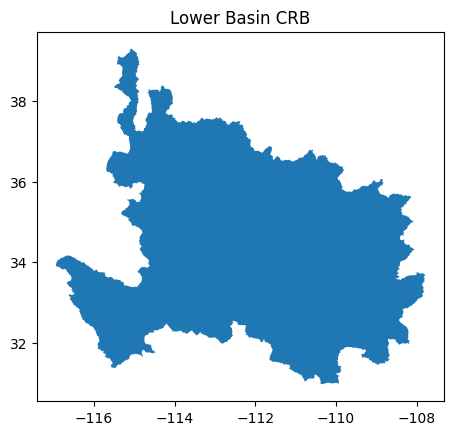

In [10]:
# plot of entire Colorado River Basin
plt.figure(figsize=[10,10])
crb.plot()
plt.title("Colorado River Basin")
plt.show()
# extracting upper and lower basin from CRB
upper_basin = crb['geometry'][7]
lower_basin = crb['geometry'][6]
#Visualising Upper and Lower Basin
gpd.GeoSeries(upper_basin).plot()
plt.title("Upper Basin CRB")
plt.show()
gpd.GeoSeries(lower_basin).plot()
plt.title("Lower Basin CRB")
plt.show()



<div class="alert alert-block alert-info" style="color: black;">
    <p><strong>Code Explanation:</strong></p>
    <p>In the code below, we first create a new column called <code>point</code> in our DataFrame <code>grace_data</code>. This column is filled with Point objects that represent the corresponding longitude and latitude values from the <code>'lon'</code> and <code>'lat'</code> columns, respectively. This is achieved by utilizing a list comprehension, which iterates over each pair of values from the <code>'lon'</code> and <code>'lat'</code> columns using the <code>zip()</code> function. The <code>zip()</code> function combines the values from the two columns based on their indices. For each pair of longitude and latitude values, a Point object is created using the <code>Point(x, y)</code> function. The resulting Point objects are then appended to the list comprehension, which populates the <code>'point'</code> column in the DataFrame.</p>
    <p>Next, in the for loop below, a new DataFrame called <code>grace_data_2</code> is created by filtering the <code>grace_data</code> DataFrame based on the following condition:</p>
    <blockquote>
        <p>Check if each point in the <code>'point'</code> column of <code>grace_data</code> is contained within the current region represented by <code>sh</code>. In each iteration, <code>sh</code> takes the value of one geometry from <code>crb["geometry"]</code>, allowing us to perform operations specific to that region.</p>
    </blockquote>
    <p>This operation filters the rows from the <code>grace_data</code> DataFrame based on whether the corresponding point in the <code>'point'</code> column falls within the current region. The filtering is performed using the <code>contains()</code> method of the region (<code>sh</code>) and the <code>'point'</code> column of <code>grace_data</code>.</p>
    <p>Finally, the filtered rows are appended to the <code>crb_data</code> DataFrame using <code>pd.concat()</code>. The iteration count is printed for tracking progress.</p>
    
</div>


<div class="alert alert-block alert-warning" style="color: black;">

<p>Note that the code provided will take some time to run, approximately 30 minutes.</p>
    
</div>

In [11]:
grace_data["point"] = [Point(x,y) for x,y in zip(grace_data["lon"],grace_data["lat"])] #creating column of Point(lon,lat)

#Keeping only rows with longitude and latitude in CRB

crb_data = pd.DataFrame()
itera = 0


for sh in crb["geometry"]: #iterating through each region in the CRB 
    
    grace_data_2 = grace_data[(sh.contains(grace_data["point"]))]
    crb_data = pd.concat([crb_data,grace_data_2])
    
    print(itera)
    itera+=1
    

crb_data =  crb_data.sort_values(by=['time'])
crb_data.reset_index(inplace=True)
    




/tmp/ipykernel_595741/2316154270.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grace_data["point"] = [Point(x,y) for x,y in zip(grace_data["lon"],grace_data["lat"])] #creating column of Point(lon,lat)


0
1
2
3
4
5
6
7



<div class="alert alert-block alert-info" style="color: black;">
Now that we have extracted the CRB region dataset from the Grace dataset.

In the code below, we plotted the monthly averages of the land water equivalent variable `lwe` over time for the CRB region. In order to plot this, we first averaged the `lwe` across latitudes and longitudes for each time point.

</div>


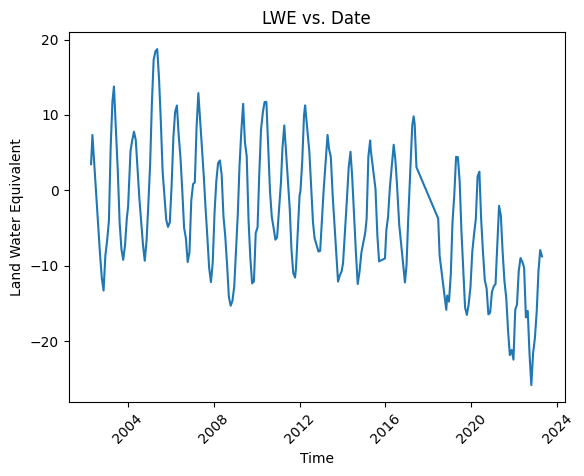

In [12]:
monthly_averages_crb = crb_data.groupby(['time']).agg({'lwe': 'mean'}).reset_index()
monthly_averages_crb

plt.plot(monthly_averages_crb['time'], monthly_averages_crb['lwe'])
plt.xlabel('Time')
plt.ylabel('Land Water Equivalent')
plt.title('LWE vs. Date')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
plt.show()


In [62]:
crb_data 

,index,time,lat,lon,lwe_thickness,scale_factor,lwe,point
0,23875280,2002-04-17 12:00:00,41.25,-104.75,1.620552,0.953967,1.545953,POINT (-104.75 41.25)
1,22604120,2002-04-17 12:00:00,36.75,-108.75,1.351319,1.481357,2.001786,POINT (-108.75 36.75)
2,20861280,2002-04-17 12:00:00,36.25,-114.25,2.922306,0.444426,1.298748,POINT (-114.25 36.25)
3,22604560,2002-04-17 12:00:00,37.25,-108.75,1.351319,0.865412,1.169449,POINT (-108.75 37.25)
4,20860840,2002-04-17 12:00:00,35.75,-114.25,2.922306,2.601101,7.601212,POINT (-114.25 35.75)
...,...,...,...,...,...,...,...,...
63575,22602798,2023-04-16 00:00:00,34.75,-108.75,-6.318313,0.877976,-5.547330,POINT (-108.75 34.75)
63576,22285558,2023-04-16 00:00:00,34.25,-109.75,-1.036462,1.472674,-1.526371,POINT (-109.75 34.25)
63577,21966998,2023-04-16 00:00:00,32.25,-110.75,-1.036462,1.002164,-1.038705,POINT (-110.75 32.25)
63578,21652838,2023-04-16 00:00:00,35.25,-111.75,-7.675123,0.509027,-3.906849,POINT (-111.75 35.25)


<div class="alert alert-block alert-info" style="color: black;">
Next, for the CRB data, we created a gif that shows the land water equiavelent of the CRB region over time. 

First, in this dataset, for each time point, we have multiple values of lon and lat so we used the Counter function from the collections package to count the occurrences of each element in the "time" column of the crb_data dataset. We accessed the distinct values found in the "time" column of the crb_data dataset, as counted by the Counter function using the keys() function. 
</div>





In [65]:
collections.Counter(crb_data["time"])
collections.Counter(crb_data["time"]).keys()


dict_keys([Timestamp('2002-04-17 12:00:00'), Timestamp('2002-05-10 12:00:00'), Timestamp('2002-08-16 12:00:00'), Timestamp('2002-09-16 00:00:00'), Timestamp('2002-10-16 12:00:00'), Timestamp('2002-11-16 00:00:00'), Timestamp('2002-12-16 12:00:00'), Timestamp('2003-01-16 12:00:00'), Timestamp('2003-02-15 00:00:00'), Timestamp('2003-03-16 12:00:00'), Timestamp('2003-04-16 00:00:00'), Timestamp('2003-05-11 12:00:00'), Timestamp('2003-07-16 12:00:00'), Timestamp('2003-08-16 12:00:00'), Timestamp('2003-09-16 00:00:00'), Timestamp('2003-10-16 00:00:00'), Timestamp('2003-11-16 00:00:00'), Timestamp('2003-12-16 12:00:00'), Timestamp('2004-01-07 12:00:00'), Timestamp('2004-02-17 00:00:00'), Timestamp('2004-03-16 12:00:00'), Timestamp('2004-04-16 00:00:00'), Timestamp('2004-05-16 12:00:00'), Timestamp('2004-06-16 00:00:00'), Timestamp('2004-07-16 12:00:00'), Timestamp('2004-08-16 12:00:00'), Timestamp('2004-09-16 00:00:00'), Timestamp('2004-10-16 12:00:00'), Timestamp('2004-11-16 00:00:00'), Tim

In [58]:

# Ensure output directory exists
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

filenames = []
i = 0

for tp in collections.Counter(crb_data["time"]).keys():
    fig, ax = plt.subplots(figsize=(12, 6))
    crb.plot(color="lightgrey", ax=ax, edgecolor='k')

    sub_df = crb_data[crb_data["time"] == tp]

    x = sub_df['lon'].values
    y = sub_df['lat'].values
    z = sub_df['lwe'].values

    plt.scatter(x, y, c=z, cmap='spring_r', marker="s", sizes=[75]*len(x))
    plt.colorbar(label='LWE')
    plt.title(str(tp)[0:10])

    # create file name and append it to a list
    filename = os.path.join(output_dir, f'{i}.png')
    i += 1
    filenames.append(filename)

    # save frame
    plt.savefig(filename)
    plt.close()

# build gif
gif_filename = "updated_grace_crb.gif"
with imageio.get_writer(gif_filename, mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Remove files
for filename in filenames:
    os.remove(filename)

print(f"GIF saved as: {gif_filename}")


/tmp/ipykernel_595741/1173266783.py:41: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as: updated_grace_crb.gif


In [59]:
from IPython.display import Image

# Display the GIF
Image(url='updated_grace_crb.gif')

<div class="alert alert-block alert-info" style="color: black;">
Next, we focused specifically on Colorado River Basin States. In the code below, we downloaded the shape file of <a href="https://coloradoriverbasin-lincolninstitute.hub.arcgis.com/datasets/lincolninstitute::colorado-river-basin-us-states/explore?location=37.912097%2C-113.261774%2C6.00">Colorado River Basin States</a> in the format of an SHP file. We also plotted the CRB states.
</div>


<Figure size 1200x1000 with 0 Axes>

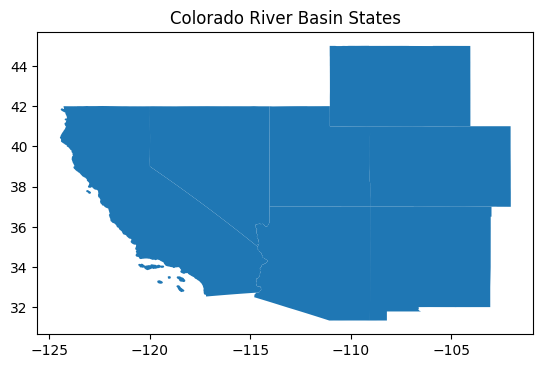

In [60]:
#Loading shapefile of CRB States (comprising of 7 total states: Wyoming, California, Utah, Arizona, Colorado, Nevada, New Mexico)
states = gpd.read_file("/home/asetia/code/Colorado_River_Basin_US_States.shp")


# plot of entire Colorado River Basin
plt.figure(figsize=[12,10])
states.plot()
plt.title("Colorado River Basin States")
plt.show()



<div class="alert alert-block alert-info" style="color: black;">
Next, we extracted only the CRB states from the GRACE region. The below code is similar to the one explained above to extract the enitre CRB region.
</div>


In [61]:

#Keeping only rows with longitude and latitude in CRB

crb_states_df = pd.DataFrame()
itera = 0


for sh in states["geometry"]: #iterating through each region in the CRB 
    
    grace_data_2 = grace_data[(sh.contains(grace_data["point"]))]
    crb_states_df = pd.concat([crb_states_df,grace_data_2])
    
    print(itera)
    itera+=1
    

crb_states_df = crb_states_df.sort_values(by=['time'])
crb_states_df.reset_index(inplace=True)
crb_states_df


0
1
2
3
4
5
6


,index,time,lat,lon,lwe_thickness,scale_factor,lwe,point
0,22599720,2002-04-17 12:00:00,31.75,-108.75,-0.754939,0.329908,-0.249060,POINT (-108.75 31.75)
1,18327760,2002-04-17 12:00:00,37.25,-122.25,1.786008,1.892921,3.380772,POINT (-122.25 37.25)
2,20546240,2002-04-17 12:00:00,38.25,-115.25,-1.433696,1.205657,-1.728545,POINT (-115.25 38.25)
3,18173320,2002-04-17 12:00:00,41.75,-122.75,1.323063,1.167518,1.544700,POINT (-122.75 41.75)
4,20546680,2002-04-17 12:00:00,38.75,-115.25,-1.433696,1.205657,-1.728545,POINT (-115.25 38.75)
...,...,...,...,...,...,...,...,...
186335,22286438,2023-04-16 00:00:00,35.25,-109.75,-7.675123,3.387633,-26.000497,POINT (-109.75 35.25)
186336,23875278,2023-04-16 00:00:00,40.75,-104.75,-3.913027,0.493055,-1.929337,POINT (-104.75 40.75)
186337,21494878,2023-04-16 00:00:00,35.75,-112.25,-7.675123,0.523137,-4.015143,POINT (-112.25 35.75)
186338,20860838,2023-04-16 00:00:00,35.25,-114.25,-6.083721,2.601101,-15.824369,POINT (-114.25 35.25)


In [68]:
filenames = []
i = 0

for tp in collections.Counter(crb_states_df["time"]).keys():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    states.plot(color="lightgrey", ax=ax, edgecolor='k')
    
    sub_df = crb_states_df[crb_states_df["time"] == tp]

    x = sub_df['lon']
    y = sub_df['lat']
    z = sub_df['lwe']
    plt.scatter(x, y, c=z,
                cmap='spring_r',marker="s", sizes=[75]*len(x))
    plt.colorbar(label='LWE')
    plt.clim(-91,82)
    plt.title(str(tp)[0:10])
    
    # plot the line chart
    #plt.plot(y[:i])
    #plt.ylim(20,50)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    i+=1
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()
# build gif
with imageio.get_writer('updated_grace_crb_states.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_595741/1616121988.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [69]:
from IPython.display import Image

# Display the GIF
Image(url='updated_grace_crb_states.gif')